In [1]:
import sys
from pathlib import Path
import os
import matplotlib
import pandas as pd
import seaborn as sns

REPO_PATH = Path.home() / "workspace/jetpointnet"
SCRIPT_PATH = REPO_PATH / "python_scripts"
sys.path.append(str(SCRIPT_PATH))

from particle import Particle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import glob
import math
import time
import pandas
from sklearn.metrics import ConfusionMatrixDisplay
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import metrics
import awkward as ak
import pyarrow.parquet as pq
from tqdm.auto import tqdm
from numpy.lib import recfunctions as rfn
from jets_training.models.JetPointNet import PointNetSegmentation
from jets_training.jets_train import (
    TRAIN_INPUTS,
    MAX_SAMPLE_LENGTH,
    baseline_configuration,
    EXPERIMENT_NAME,
    TRAIN
)
from data_processing.jets.preprocessing_header import NPZ_SAVE_LOC, POINT_TYPE_ENCODING

OUTPUT_ACTIVATION_FUNCTION = baseline_configuration['OUTPUT_ACTIVATION_FUNCTION']
FRACTIONAL_ENERGY_CUTOFF = baseline_configuration['FRACTIONAL_ENERGY_CUTOFF']
OUTPUT_LAYER_SEGMENTATION_CUTOFF = baseline_configuration['OUTPUT_LAYER_SEGMENTATION_CUTOFF']

# there is an issue that these are needed
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Suppress the specific warning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

model = PointNetSegmentation(MAX_SAMPLE_LENGTH, 
                             num_features=len(TRAIN_INPUTS), 
                             num_classes=1, 
                             output_activation_function=OUTPUT_ACTIVATION_FUNCTION)

2024-07-08 23:41:03.299803: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-08 23:41:03.400807: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 23:41:03.400876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 23:41:03.404158: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-08 23:41:03.420803: I tensorflow/core/platform/cpu_feature_guar

Logged in as jhimmens


2024-07-08 23:41:08.962239: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46339 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:1b:00.0, compute capability: 8.6
2024-07-08 23:41:08.963481: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46602 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:1c:00.0, compute capability: 8.6
2024-07-08 23:41:08.964448: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 18147 MB memory:  -> device: 2, name: NVIDIA RTX A6000, pci bus id: 0000:4f:00.0, compute capability: 8.6
2024-07-08 23:41:08.965369: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 25395 MB memory:  -> device: 3, name: NVIDIA RTX A6000, pci bus id: 0000:50:00.0, 

In [2]:
PLOT_NON_FOCAL = True
USE_BINARY_ATTRIBUTION_MODEL = True
USE_BINARY_ATTRIBUTION_TRUTH = True
RENDER_IMAGES = True
USE_TRUTH_E = False

In [13]:
MAX_FILES = 1
MAX_WINDOWS = 10 # can take -1 for all

NPZ_LOC = NPZ_SAVE_LOC(TRAIN)
model_path = "/home/jhimmens/workspace/jetpointnet/models/full_set/direct_training/PointNet_epoch=10_name=ethereal-leaf-856.keras"
VISUALIZE_SETS = ['JZ2', 'JZ3']

In [14]:

model.load_weights(model_path)

MODEL_NAME = model_path.split('/')[-1]
VISUAL_PATH = REPO_PATH / "visualizations" / EXPERIMENT_NAME / MODEL_NAME
VISUAL_PATH.mkdir(exist_ok=True, parents=True)
TRACK_IMAGE_PATH = VISUAL_PATH / "track_images"
TRACK_IMAGE_PATH.mkdir(exist_ok=True)
HIST_PATH = VISUAL_PATH / "meta_results"
HIST_PATH.mkdir(exist_ok=True)

# Generate Event Images

In [15]:
def load_data_from_npz(npz_file):
    all_feats = np.load(npz_file)["feats"]
    feats = all_feats[:, :MAX_SAMPLE_LENGTH]  # discard tracking information
    frac_labels = all_feats[:, :MAX_SAMPLE_LENGTH]["truth_cell_fraction_energy"]
    energy_weights = all_feats[:, :MAX_SAMPLE_LENGTH]["cell_E"]
    return feats, frac_labels, energy_weights

metadata_list = []
SET_UNDER_INVESTIGATION = 'train'

for set_name in VISUALIZE_SETS:
    images_rendered = 0
    for file_idx, data_file in enumerate(glob.glob(os.path.join(NPZ_LOC / SET_UNDER_INVESTIGATION / set_name, "*.npz"))):
        print(data_file)
        if file_idx >= MAX_FILES:
            break
        filename_npz = data_file
        feats, fractional_energy, total_cell_energy = load_data_from_npz(filename_npz)

        filtered_features = feats[TRAIN_INPUTS]

        unstructured_filtered_features = rfn.structured_to_unstructured(filtered_features)

        # get prediction
        model_results = model.predict(unstructured_filtered_features)

        # image creation loop
        for window_index, window in enumerate(feats):

            name = f'Focal Track - ID: {window[0]["track_ID"]}' # add PDGID name??

            focus_hit_x = []
            focus_hit_y = []
            focus_hit_z = []

            cell_x_list = []
            cell_y_list = []
            cell_z_list = []
            cell_model_attribution = []
            cell_truth_attribution = []
            cell_total_energy = []

            non_focus_tracks = {}
            delta_r_dict = {}
            pt_dict = {}

            for point_index, point in enumerate(window):
                # this would be much nicer as a match-case statement, but it kept giving me issues
                if point['category'] == POINT_TYPE_ENCODING["focus hit"]:
                    focus_hit_x.append(point["normalized_x"])
                    focus_hit_y.append(point["normalized_y"])
                    focus_hit_z.append(point["normalized_z"])
                elif point['category'] == POINT_TYPE_ENCODING["cell"]:
                    cell_x_list.append(point["normalized_x"])
                    cell_y_list.append(point["normalized_y"])
                    cell_z_list.append(point["normalized_z"])
                    cell_total_energy.append(point["cell_E"])
                    if USE_BINARY_ATTRIBUTION_MODEL:
                        cell_model_attribution.append(int(model_results[window_index][point_index] >= OUTPUT_LAYER_SEGMENTATION_CUTOFF))
                    else:
                        cell_model_attribution.append(model_results[window_index][point_index])
                    if USE_BINARY_ATTRIBUTION_TRUTH:
                        cell_truth_attribution.append(int(fractional_energy[window_index][point_index] >= FRACTIONAL_ENERGY_CUTOFF))
                    else:
                        cell_truth_attribution.append(fractional_energy[window_index][point_index])
                elif point['category'] == POINT_TYPE_ENCODING["unfocus hit"]:
                    if point['track_ID'] in non_focus_tracks:
                        non_focus_tracks[point['track_ID']]['non_focus_hit_x'].append(point["normalized_x"])
                        non_focus_tracks[point['track_ID']]['non_focus_hit_y'].append(point["normalized_y"])
                        non_focus_tracks[point['track_ID']]['non_focus_hit_z'].append(point["normalized_z"])
                    else:
                        non_focus_tracks[point['track_ID']] = {
                            'non_focus_hit_x': [point["normalized_x"]],
                            'non_focus_hit_y': [point["normalized_y"]],
                            'non_focus_hit_z': [point["normalized_z"]],
                            'non_focus_pt': point["track_pt"],
                            'delta_R': point["delta_R"],
                        }
                elif point['category'] == POINT_TYPE_ENCODING["padding"]:
                    pass
                else:
                    raise Exception("Unknown point in npz files!")

            cell_truth_attribution = np.array(cell_truth_attribution)
            cell_model_attribution = np.array(cell_model_attribution)

            nCells = len(cell_x_list)

            y_true = (cell_truth_attribution == 1).astype(np.float32)
            y_pred = (cell_model_attribution == 1).astype(np.float32)

            tp = np.sum((cell_model_attribution == 1) & (cell_truth_attribution == 1))
            fp = np.sum((cell_model_attribution == 1) & (cell_truth_attribution == 0))
            tn = np.sum((cell_model_attribution == 0) & (cell_truth_attribution == 0))
            fn = np.sum((cell_model_attribution == 0) & (cell_truth_attribution == 1))
            positive = np.sum(cell_truth_attribution == 1)
            negative = np.sum(cell_truth_attribution == 0)
            predicted_positive = np.sum(cell_model_attribution == 1)
            predicted_negative = np.sum(cell_model_attribution == 0)

            valid_cell_mask = window['category'] == 1

            activated_energy = np.sum(window['cell_E'][valid_cell_mask][(cell_model_attribution == 1)])
            ideal_activation_energy = np.sum(window['cell_E'][valid_cell_mask][(cell_truth_attribution == 1)])
            total_truth_track_energy = np.sum(window["truth_cell_total_energy"][valid_cell_mask] * window["truth_cell_fraction_energy"][valid_cell_mask])
            
            average_energy = np.mean(window["cell_E"])
            average_truth_energy = np.mean(window["truth_cell_total_energy"][valid_cell_mask] * window["truth_cell_fraction_energy"][valid_cell_mask])

            #tp_rate_partial = tp / n_postive_true_hits
            #fp_rate_partial = fp / nCells
            #tn_rate_partial = tn / n_negative_true_hits
            #fn_rate_partial = fn / nCells

            track_information = {
                'set_name': set_name,
                'track_ID': window['track_ID'][0],
                'total_truth_track_E': np.sum(window["truth_cell_total_energy"][valid_cell_mask] * window["truth_cell_fraction_energy"][valid_cell_mask]),
                'total_real_E': np.sum(window["cell_E"][valid_cell_mask]),
                'track_pt': window['track_pt'][0],
                'total_truth_energy': total_truth_track_energy,
                'activated_energy': activated_energy,
                'ideal_activation_energy': ideal_activation_energy,
                'truth_attributions': positive,
                'rate_truth_activations': np.sum(cell_truth_attribution == 1)/nCells,
                'model_attributions': predicted_positive,
                'n_non_focal_tracks': len(non_focus_tracks),
                'n_cells': nCells,
                'num_correct_predictions': np.sum(cell_truth_attribution == cell_model_attribution),
                'dumb_accuracy': max(positive, negative)/nCells,
                'positive_dumb_accuracy': positive/nCells,
                'negative_dumb_accuracy': negative/nCells,
                'accuracy': np.sum(cell_truth_attribution == cell_model_attribution)/nCells,
                'average_energy': average_energy,
                'average_truth_energy': average_truth_energy,
                # see https://en.wikipedia.org/wiki/Confusion_matrix
                'num_false_positives': fp,
                'num_false_negatives': fn,
                'num_true_positives': tp,
                'num_true_negatives': tn,
                # for the 4 below, manual implementation has a much faster run time
                'precision_score': metrics.precision_score(y_true, y_pred),
                'recall_score': metrics.recall_score(y_true, y_pred),
                'f1_score': metrics.f1_score(y_true, y_pred),
                'hamming_loss': metrics.hamming_loss(y_true, y_pred),
                # assorted, less useful stats, could delete?
                'false_positive_rate': fp/negative if negative != 0 else 0,
                'false_negative_rate': fn/positive if positive != 0 else 0,
                'true_positive_rate': tp/positive if positive != 0 else 0,
                'true_negative_rate': tn/negative if negative != 0 else 0,
                'positive_predictive_value': tp/predicted_positive if predicted_positive != 0 else 0,
                'false_discovery_rate': fp/predicted_positive if predicted_positive != 0 else 0,
                'false_omission_rate': fn/predicted_negative if predicted_negative != 0 else 0,
                'negative_predictive_value': tn/predicted_negative if predicted_negative != 0 else 0,
                'threat_score': tp/(tp+fn+fp) if tp+fn+fp != 0 else 0,
                #potential to add data from awk files like PDG ID, Chi^2/dof
            }

            # model performace

            metadata_list.append(track_information)

            if (RENDER_IMAGES and (MAX_WINDOWS == -1 or images_rendered < MAX_WINDOWS)) or nCells > 1000:
                images_rendered += 1
                # convert to plot:
                fig = plt.figure(figsize=(22, 7))
                fig.suptitle(f'Set: {set_name}, Accuracy factor: {np.sum(cell_truth_attribution == cell_model_attribution)/max(positive, negative):.2f}, Event: {window[0]["event_number"]} Track: {window[0]["track_ID"]}, $\sum E={sum(cell_total_energy):.2f}$, nCells={len(cell_x_list)}, pt={window["track_pt"][0]:.2f}, activated_energy: {float(activated_energy):.4f}, ideal_activation_energy: {ideal_activation_energy:.4f}, truth track E: {total_truth_track_energy:.5f}')

                ax1 = fig.add_subplot(131, projection='3d')
                ax2 = fig.add_subplot(132, projection='3d')
                ax3 = fig.add_subplot(133, projection='3d')

                ax_list = [ax1, ax2, ax3]

                for ax_i in ax_list:
                    ax_i.plot(focus_hit_x, focus_hit_y, focus_hit_z, label=name)
                    if PLOT_NON_FOCAL:
                        for non_focal_id, non_focal_track in non_focus_tracks.items():
                            ax_i.plot(non_focal_track['non_focus_hit_x'],
                                    non_focal_track['non_focus_hit_y'], 
                                    non_focal_track['non_focus_hit_z'], 
                                    label=f"Non Focal - ID: {non_focal_id}")
                        ax_i.legend()
                    ax_i.set_xlabel('X Coordinate (mm)')
                    ax_i.set_ylabel('Y Coordinate (mm)')
                    ax_i.set_zlabel('Z Coordinate (mm)')

                # First subplot
                ax1.set_title(f'Model Prediction - {np.sum(cell_model_attribution)} activations')
                sc1 = ax1.scatter(cell_x_list, cell_y_list, cell_z_list, c=cell_model_attribution, cmap='jet', vmin=0, vmax=1)
                cbar1 = plt.colorbar(sc1, ax=ax1)
                cbar1.set_label('Model Output')
                
                # Second subplot
                ax2.set_title(f'Truth Values - {np.sum(cell_truth_attribution)} activations')
                sc2 = ax2.scatter(cell_x_list, cell_y_list, cell_z_list, c=cell_truth_attribution, cmap='jet', vmin=0, vmax=1)
                cbar2 = plt.colorbar(sc2, ax=ax2)
                cbar2.set_label('frac_E')
                
                # Third subplot, total energies

                if USE_TRUTH_E:
                    ax3.set_title(f'Cell Energies (Truth)')
                else:
                    ax3.set_title(f'Cell Energies (Not Truth)')
                cell_x_array_np = np.array(cell_x_list)
                cell_y_array_np = np.array(cell_y_list)
                cell_z_array_np = np.array(cell_z_list)
                cell_total_energy_array = np.array(cell_total_energy)

                mask = np.array(cell_total_energy) > 0

                # Ensure normalization is consistent with LogNorm only for positive values
                if np.any(mask):
                    sc3 = ax3.scatter(cell_x_array_np[mask], cell_y_array_np[mask], cell_z_array_np[mask], c=cell_total_energy_array[mask], cmap='jet', norm=LogNorm())
                else:
                    sc3 = ax3.scatter(cell_x_array_np, cell_y_array_np, cell_z_array_np, cmap='jet')

                cbar3 = plt.colorbar(sc3, ax=ax3)
                cbar3.set_label('Total_Label (MeV)')

                plt.tight_layout()
                print(f"saving: event={window[0]['event_number']:09}_track={window[0]['track_ID']:03}")
                SET_IMAGE_PATH = TRACK_IMAGE_PATH / set_name
                SET_IMAGE_PATH.mkdir(exist_ok=True)
                plt.savefig(SET_IMAGE_PATH / f"event={window[0]['event_number']:09}_track={window[0]['track_ID']:03}.png")
                plt.close()
            
metadata = pd.DataFrame(metadata_list)
metadata.to_csv(HIST_PATH / "metadata.csv")
                

JZ2
/fast_scratch_1/atlas/pflow/jhimmens_working_files/pnet_data/processed_files/collected_data/rev_2/SavedNpz/deltaR=0.2_maxLen=800_EScale=1/train/JZ2/*.npz
['/fast_scratch_1/atlas/pflow/jhimmens_working_files/pnet_data/processed_files/collected_data/rev_2/SavedNpz/deltaR=0.2_maxLen=800_EScale=1/train/JZ2/user.mswiatlo.39955678._000016.mltree.root_chunk_0_train.parquet.npz', '/fast_scratch_1/atlas/pflow/jhimmens_working_files/pnet_data/processed_files/collected_data/rev_2/SavedNpz/deltaR=0.2_maxLen=800_EScale=1/train/JZ2/user.mswiatlo.39955678._000294.mltree.root_chunk_0_train.parquet.npz', '/fast_scratch_1/atlas/pflow/jhimmens_working_files/pnet_data/processed_files/collected_data/rev_2/SavedNpz/deltaR=0.2_maxLen=800_EScale=1/train/JZ2/user.mswiatlo.39955678._000576.mltree.root_chunk_0_train.parquet.npz', '/fast_scratch_1/atlas/pflow/jhimmens_working_files/pnet_data/processed_files/collected_data/rev_2/SavedNpz/deltaR=0.2_maxLen=800_EScale=1/train/JZ2/user.mswiatlo.39955678._000105.m

# Generate Histograms

In [43]:
left_sets = ['JZ2']
right_sets = ['JZ3']

if not set(left_sets).issubset(set(VISUALIZE_SETS)):
        raise ValueError(f"left_sets is not a subset of VISUALIZE_SETS")

if not set(right_sets).issubset(set(VISUALIZE_SETS)):
        raise ValueError(f"right_sets is not a subset of VISUALIZE_SETS")

# Filter the data for LEFT and RIGHT
metadata_left = metadata[metadata['set_name'].isin(left_sets)]
metadata_right = metadata[metadata['set_name'].isin(right_sets)]
left_description = ' '.join(left_sets)
right_description = ' '.join(right_sets)
left_n_events = len(metadata_left)
right_n_events = len(metadata_right)

FIG_SIZE=(15, 5)

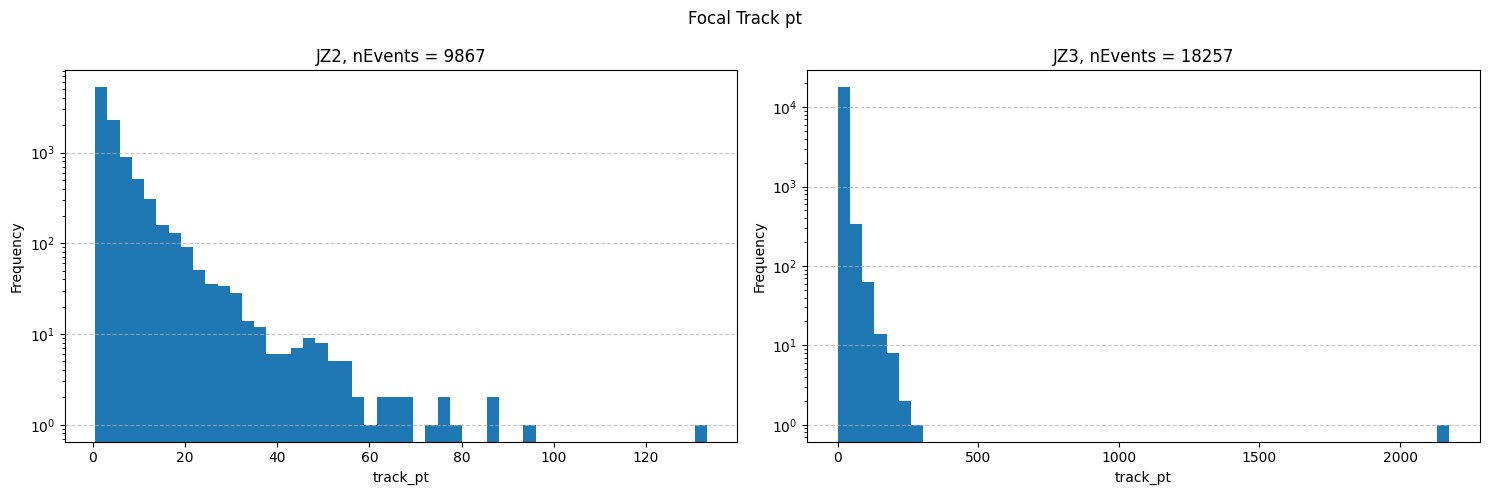

<Figure size 640x480 with 0 Axes>

In [44]:
plot_data = 'track_pt'

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=FIG_SIZE)
fig.suptitle('Focal Track pt')

# Plot for LEFT
axs[0].hist(metadata_left[plot_data], bins=50, label="track_pt")
axs[0].set_title(f'{left_description}, nEvents = {left_n_events}')
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
axs[0].set_yscale('log')
axs[0].set_xlabel(plot_data)
axs[0].set_ylabel('Frequency')

# Plot for RIGHT
axs[1].hist(metadata_right[plot_data], bins=50, label="track_pt")
axs[1].set_title(f'{right_description}, nEvents = {right_n_events}')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
axs[1].set_yscale('log')
axs[1].set_xlabel(plot_data)
axs[1].set_ylabel('Frequency')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
plt.clf()

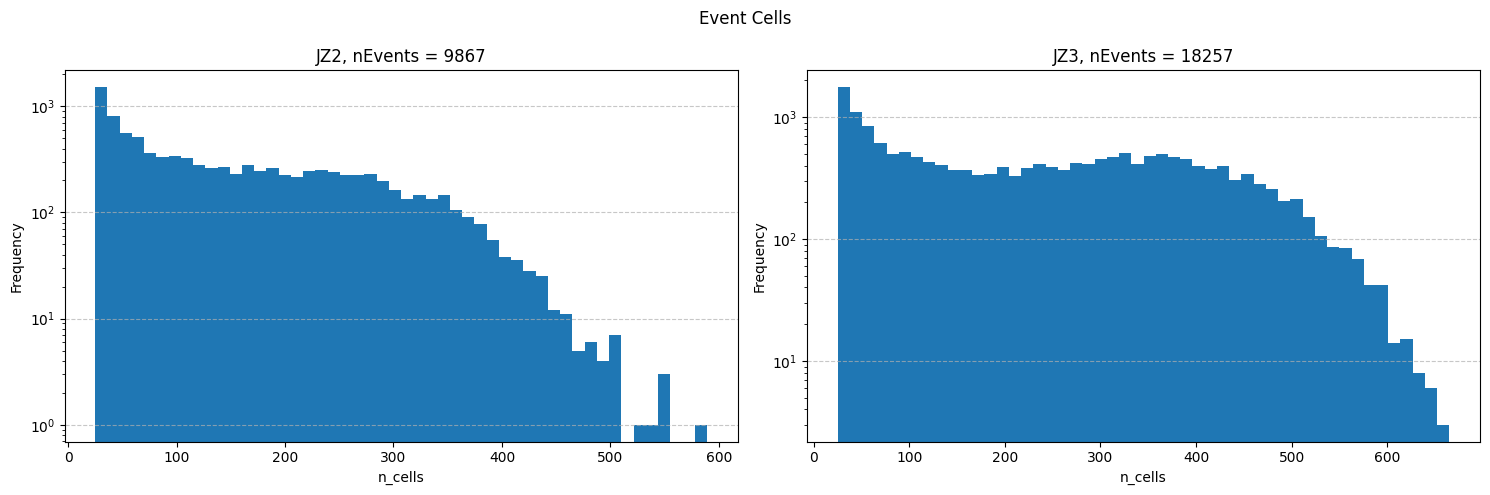

<Figure size 640x480 with 0 Axes>

In [45]:
plot_data = 'n_cells'

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=FIG_SIZE)
fig.suptitle("Event Cells")
# Plot for LEFT
axs[0].hist(metadata_left[plot_data], bins=50, label="track_pt")
axs[0].set_title(f'{left_description}, nEvents = {left_n_events}')
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
axs[0].set_yscale('log')
axs[0].set_xlabel(plot_data)
axs[0].set_ylabel('Frequency')

# Plot for RIGHT
axs[1].hist(metadata_right[plot_data], bins=50, label="track_pt")
axs[1].set_title(f'{right_description}, nEvents = {right_n_events}')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
axs[1].set_yscale('log')
axs[1].set_xlabel(plot_data)
axs[1].set_ylabel('Frequency')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
plt.clf()

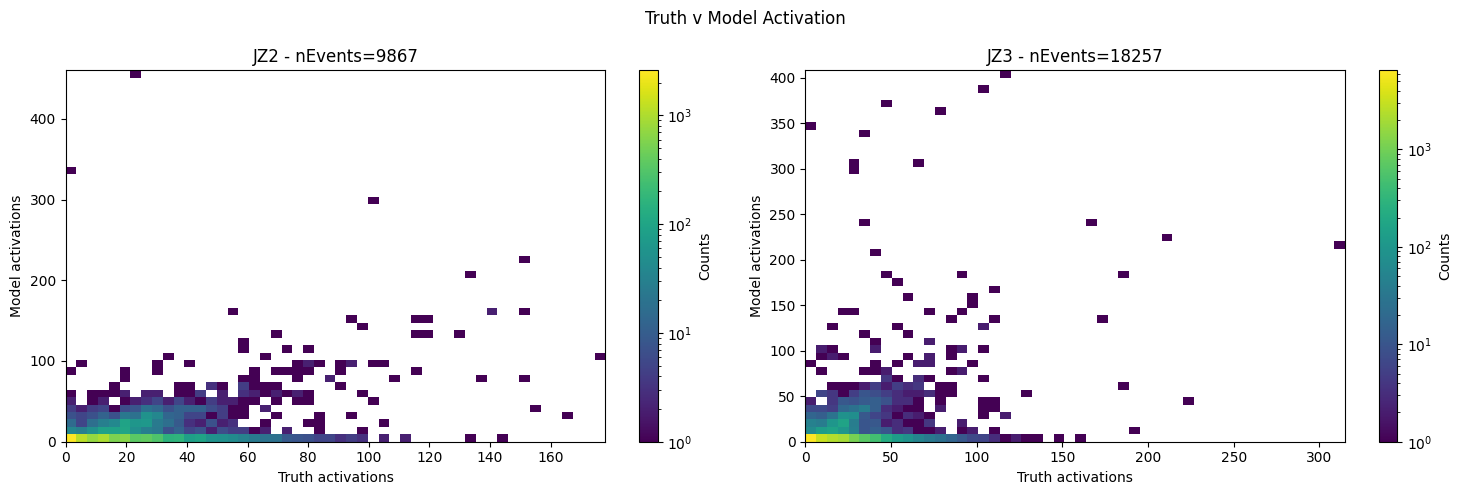

<Figure size 640x480 with 0 Axes>

In [48]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=FIG_SIZE)
fig.suptitle("Truth v Model Activation")
# Plot for LEFT
_, _, _, im_left = axs[0].hist2d(metadata_left['truth_attributions'], metadata_left['model_attributions'], bins=50, cmap='viridis', norm=LogNorm())
axs[0].set_title(f'{left_description} - nEvents={left_n_events}')
axs[0].set_xlabel('Truth activations')
axs[0].set_ylabel('Model activations')
#axs[0].colorbar(label='Counts')
fig.colorbar(im_left, ax=axs[0], label='Counts')

# Plot for RIGHT
_, _, _, im_right = axs[1].hist2d(metadata_right['truth_attributions'], metadata_right['model_attributions'], bins=50, cmap='viridis', norm=LogNorm())
axs[1].set_title(f'{right_description} - nEvents={right_n_events}')
axs[1].set_xlabel('Truth activations')
axs[1].set_ylabel('Model activations')
fig.colorbar(im_right, ax=axs[1], label='Counts')

plt.tight_layout()
plt.show()
plt.clf()

In [ ]:
x_data = 'n_cells'
y_data = 'model_attributions'

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=FIG_SIZE)
fig.suptitle("Model Activations to Number of Cells")
# Plot for LEFT
axs[0].hist2d(metadata_left[x_data], metadata_left[y_data], bins=50, cmap='viridis', norm=LogNorm())
axs[0].set_title(f'Truth to Model activations with nTracks={left_n_events}')
axs[0].set_xlabel(x_data)
axs[0].set_ylabel(y_data)
axs[0].colorbar(label='Counts')

# Plot for RIGHT
axs[1].hist2d(metadata_right[x_data], metadata_right[y_data], bins=50, cmap='viridis', norm=LogNorm())
axs[1].set_title(f'Truth to Model activations with nTracks={right_n_events}')
axs[1].set_xlabel(x_data)
axs[1].set_ylabel(y_data)
axs[1].colorbar(label='Counts')

# Save the plot
plt.tight_layout()
plt.show()
plt.clf()

In [ ]:
plt.title("Model activated energy to total truth energy")
x_data = 'activated_energy'
y_data = 'total_truth_energy'

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=FIG_SIZE)

# Plot for LEFT
axs[0].hist2d(metadata_left[x_data], metadata_left[y_data], bins=50, cmap='viridis', norm=LogNorm())
axs[0].set_title(f'Truth to Model activations with nTracks={left_n_events}')
axs[0].set_xlabel(x_data)
axs[0].set_ylabel(y_data)
axs[0].colorbar(label='Counts')

# Plot for RIGHT
axs[1].hist2d(metadata_right[x_data], metadata_right[y_data], bins=50, cmap='viridis', norm=LogNorm())
axs[1].set_title(f'Truth to Model activations with nTracks={right_n_events}')
axs[1].set_xlabel(x_data)
axs[1].set_ylabel(y_data)
axs[1].colorbar(label='Counts')

# Save the plot
plt.tight_layout()
plt.show()
plt.clf()

In [ ]:
plt.title("Model activated energy to truth track E")
x_data = 'activated_energy'
y_data = 'total_truth_track_E'

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=FIG_SIZE)

# Plot for LEFT
axs[0].hist2d(metadata_left[x_data], metadata_left[y_data], bins=50, cmap='viridis', norm=LogNorm())
axs[0].set_title(f'Truth to Model activations with nTracks={left_n_events}')
axs[0].set_xlabel(x_data)
axs[0].set_ylabel(y_data)
axs[0].colorbar(label='Counts')

# Plot for RIGHT
axs[1].hist2d(metadata_right[x_data], metadata_right[y_data], bins=50, cmap='viridis', norm=LogNorm())
axs[1].set_title(f'Truth to Model activations with nTracks={right_n_events}')
axs[1].set_xlabel(x_data)
axs[1].set_ylabel(y_data)
axs[1].colorbar(label='Counts')

# Save the plot
plt.tight_layout()
plt.show()
plt.clf()